# Trying WGAN with MNIST

In [1]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from tensorflow.python import debug as tf_debug
import tensorflow.contrib as tc
import tensorflow.contrib.layers as tcl

%matplotlib inline

/home/rluo/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3143037101690312620, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10761938535
 locality {
   bus_id: 1
 }
 incarnation: 5562016540954068740
 physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:01:00.0, compute capability: 5.2", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 11989689959
 locality {
   bus_id: 1
 }
 incarnation: 10358189792398205104
 physical_device_desc: "device: 1, name: GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2"]

In [2]:
h1_dim = 256
h2_dim = 512
dim = 100
batch_size = 64

In [3]:
def generator_(gen_weights, z_noise):
    w1, b1, w2, b2, w3, b3 = gen_weights
    h1 = tf.nn.relu(tf.matmul(z_noise, w1) + b1)
    h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)
    h3 = tf.matmul(h2, w3) + b3
    out_gen = tf.nn.sigmoid(h3)
    return out_gen
    
def generator_weights():
    w1 = tf.Variable(tf.truncated_normal([dim, h1_dim], stddev=0.1), name="w1_g", dtype=tf.float32)
    b1 = tf.Variable(tf.zeros([h1_dim]), name="b1_g", dtype=tf.float32)
    w2 = tf.Variable(tf.truncated_normal([h1_dim, h2_dim], stddev=0.1), name="w2_g", dtype=tf.float32)
    b2 = tf.Variable(tf.zeros([h2_dim]), name="b2_g", dtype=tf.float32)
    w3 = tf.Variable(tf.truncated_normal([h2_dim, 28 * 28], stddev=0.1), name="w3_g", dtype=tf.float32)
    b3 = tf.Variable(tf.zeros([28*28]), name="b3_g", dtype=tf.float32)
    weights_g = [w1, b1, w2, b2, w3, b3]
    return weights_g

In [4]:
def discriminator_(x, disc_weights, keep_prob):
    w1, b1, w2, b2, w3, b3 = disc_weights
    h1 = tf.nn.dropout(tf.nn.relu(tf.matmul(x, w1) + b1), keep_prob)
    h2 = tf.nn.dropout(tf.nn.relu(tf.matmul(h1,w2) + b2), keep_prob)
    h3 = tf.matmul(h2, w3) + b3
    y = tf.nn.sigmoid(h3)
    return y
    
def discriminator_weights():
    w1 = tf.Variable(tf.truncated_normal([28*28, h2_dim], stddev=0.1), name="w1_d", dtype=tf.float32)
    b1 = tf.Variable(tf.zeros([h2_dim]), name="b1_d", dtype=tf.float32)
    w2 = tf.Variable(tf.truncated_normal([h2_dim, h1_dim], stddev=0.1), name="w2_d", dtype=tf.float32)
    b2 = tf.Variable(tf.zeros([h1_dim]), name="b2_d", dtype=tf.float32)
    w3 = tf.Variable(tf.truncated_normal([h1_dim, 1], stddev=0.1), name="w3_d", dtype=tf.float32)
    b3 = tf.Variable(tf.zeros([1]), name="b3_d", dtype=tf.float32)

    weights_d = [w1, b1, w2, b2, w3, b3]
    return weights_d

In [5]:
with tf.device('/device:GPU:0'):


    # Read the MNIST datadet
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
    ## Place holder for the real images
    x = tf.placeholder(tf.float32, [batch_size, 28*28], name="x_data")
    ## Place holder for the noise
    z_noise = tf.placeholder(tf.float32, [batch_size, dim], name="z_prior")
    ## Dropout probability
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    weights_g = generator_weights()
    # generate the output op for    generator and also define the weights.
    out_gen = generator_(weights_g, z_noise)
    # Define the ops and weights for Discriminator
    weights_d = discriminator_weights()
    y_data = discriminator_(x, weights_d, keep_prob)
    y_fake = discriminator_(out_gen, weights_d, keep_prob)

    eps = tf.random_uniform([batch_size, 1])
    x_hat = eps * x + (1 - eps) * out_gen
    y_mid = discriminator_(x_hat, weights_d, keep_prob)

    lam = 10
    gradients = tf.gradients(y_mid, x_hat)[0]
    disc_loss = tf.reduce_mean(y_fake) - tf.reduce_mean(y_data) + lam * tf.reduce_mean(tf.square(tf.norm(gradients, axis=1) - 1))

    gen_loss = -tf.reduce_mean(y_fake)

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_trainer = tf.train.AdamOptimizer(0.0001, 0.1, 0.9).minimize(disc_loss, var_list=weights_d)
        g_trainer = tf.train.AdamOptimizer(0.0001, 0.1, 0.9).minimize(gen_loss, var_list=weights_g)
    
    init = tf.global_variables_initializer()
    
    disc_grad = tf.gradients(disc_loss, weights_d)
    gen_grad = tf.gradients(gen_loss, weights_g)

    
gpu_options = tf.GPUOptions(allow_growth=False)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


iter: 1000 cost of discriminator -0.29523194 cost of generator -0.35617
mean predicted prob for actual data: 0.79538494348526, mean predicted prob for fake data: 0.35616999864578247


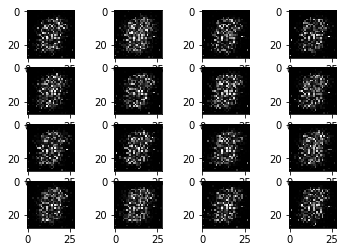

iter: 2000 cost of discriminator -0.18347406 cost of generator -0.39626834
mean predicted prob for actual data: 0.8291741609573364, mean predicted prob for fake data: 0.3962683379650116


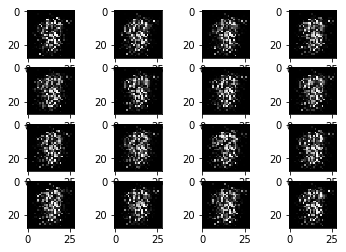

iter: 3000 cost of discriminator -0.28571078 cost of generator -0.3023672
mean predicted prob for actual data: 0.7033874988555908, mean predicted prob for fake data: 0.3023672103881836


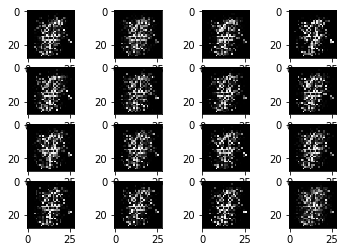

iter: 4000 cost of discriminator -0.31833318 cost of generator -0.3425874
mean predicted prob for actual data: 0.7010750770568848, mean predicted prob for fake data: 0.342587411403656


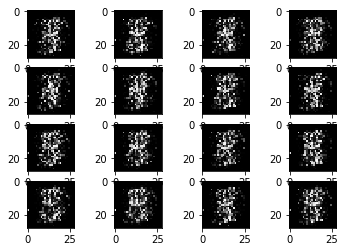

iter: 5000 cost of discriminator -0.28546458 cost of generator -0.30249768
mean predicted prob for actual data: 0.674014687538147, mean predicted prob for fake data: 0.3024976849555969


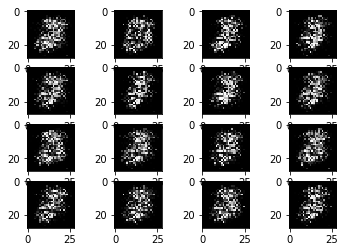

iter: 6000 cost of discriminator -0.2649932 cost of generator -0.30056387
mean predicted prob for actual data: 0.653573751449585, mean predicted prob for fake data: 0.30056387186050415


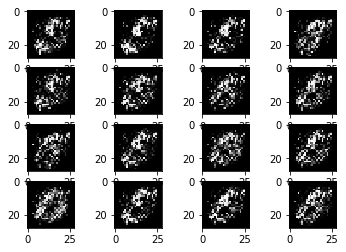

iter: 7000 cost of discriminator -0.2778666 cost of generator -0.28754348
mean predicted prob for actual data: 0.6638933420181274, mean predicted prob for fake data: 0.28754347562789917


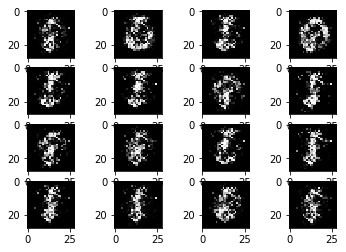

iter: 8000 cost of discriminator -0.21004666 cost of generator -0.3497571
mean predicted prob for actual data: 0.6110604405403137, mean predicted prob for fake data: 0.3497571051120758


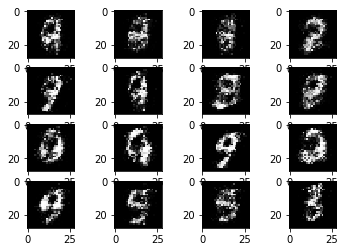

iter: 9000 cost of discriminator -0.2989911 cost of generator -0.35189015
mean predicted prob for actual data: 0.6953551173210144, mean predicted prob for fake data: 0.3518901467323303


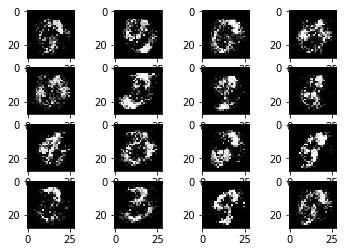

iter: 10000 cost of discriminator -0.2501598 cost of generator -0.4024117
mean predicted prob for actual data: 0.7225437164306641, mean predicted prob for fake data: 0.40241169929504395


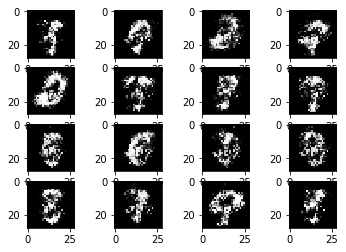

iter: 11000 cost of discriminator -0.24643606 cost of generator -0.43060213
mean predicted prob for actual data: 0.7520766258239746, mean predicted prob for fake data: 0.43060213327407837


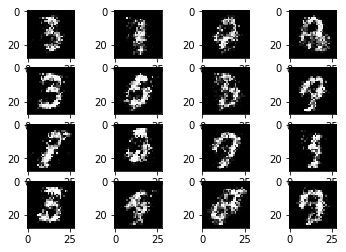

iter: 12000 cost of discriminator -0.24420099 cost of generator -0.33153072
mean predicted prob for actual data: 0.6874454617500305, mean predicted prob for fake data: 0.33153071999549866


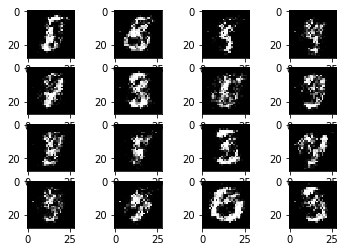

iter: 13000 cost of discriminator -0.14420804 cost of generator -0.4837929
mean predicted prob for actual data: 0.828156054019928, mean predicted prob for fake data: 0.48379290103912354


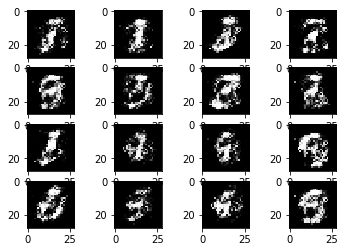

iter: 14000 cost of discriminator -0.21606024 cost of generator -0.43282467
mean predicted prob for actual data: 0.7651698589324951, mean predicted prob for fake data: 0.43282467126846313


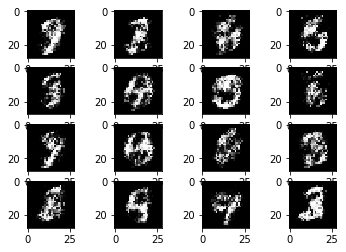

iter: 15000 cost of discriminator -0.25569704 cost of generator -0.39488363
mean predicted prob for actual data: 0.7185719013214111, mean predicted prob for fake data: 0.3948836326599121


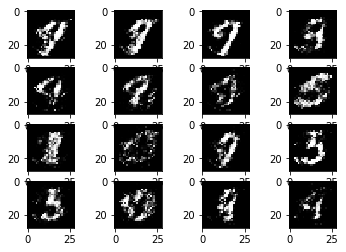

iter: 16000 cost of discriminator -0.31658813 cost of generator -0.35682842
mean predicted prob for actual data: 0.7435814738273621, mean predicted prob for fake data: 0.3568284213542938


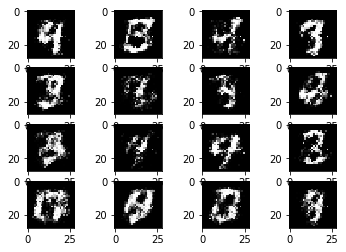

iter: 17000 cost of discriminator -0.30958357 cost of generator -0.32206535
mean predicted prob for actual data: 0.718475341796875, mean predicted prob for fake data: 0.3220653533935547


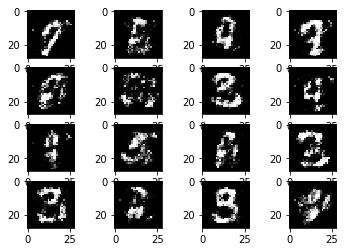

iter: 18000 cost of discriminator -0.26782894 cost of generator -0.35449487
mean predicted prob for actual data: 0.7232142686843872, mean predicted prob for fake data: 0.3544948697090149


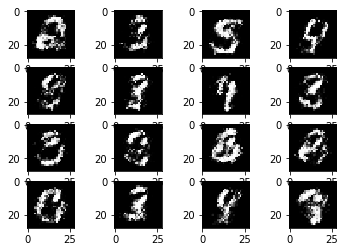

iter: 19000 cost of discriminator -0.21751243 cost of generator -0.40600353
mean predicted prob for actual data: 0.7389940619468689, mean predicted prob for fake data: 0.40600353479385376


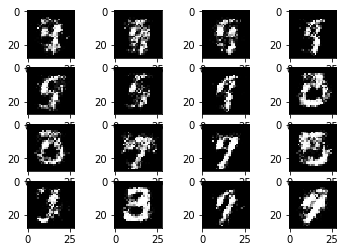

iter: 20000 cost of discriminator -0.22999786 cost of generator -0.36889386
mean predicted prob for actual data: 0.7037982940673828, mean predicted prob for fake data: 0.3688938617706299


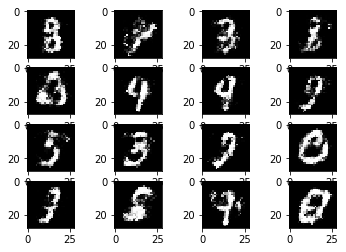

iter: 21000 cost of discriminator -0.26980838 cost of generator -0.42886522
mean predicted prob for actual data: 0.7880420684814453, mean predicted prob for fake data: 0.4288652241230011


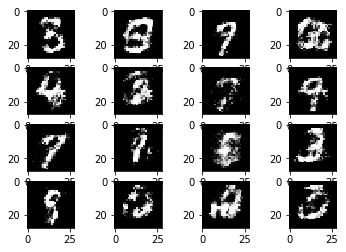

iter: 22000 cost of discriminator -0.25836664 cost of generator -0.40324223
mean predicted prob for actual data: 0.7203823924064636, mean predicted prob for fake data: 0.40324223041534424


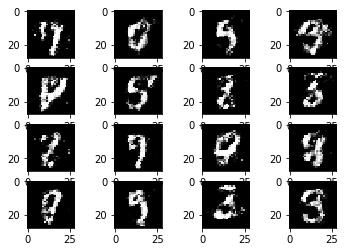

iter: 23000 cost of discriminator -0.18681966 cost of generator -0.46918046
mean predicted prob for actual data: 0.7769141793251038, mean predicted prob for fake data: 0.46918046474456787


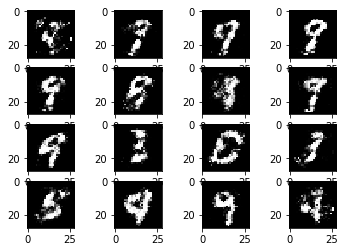

iter: 24000 cost of discriminator -0.25312564 cost of generator -0.42231137
mean predicted prob for actual data: 0.7570227384567261, mean predicted prob for fake data: 0.42231136560440063


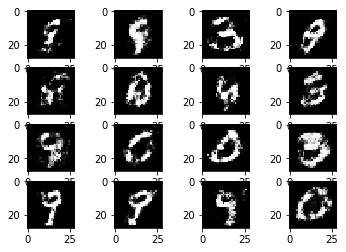

iter: 25000 cost of discriminator -0.27748132 cost of generator -0.30979517
mean predicted prob for actual data: 0.6619361639022827, mean predicted prob for fake data: 0.30979517102241516


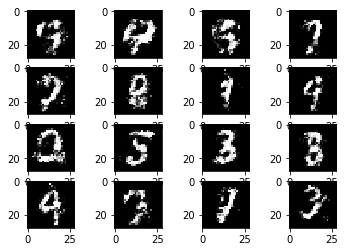

iter: 26000 cost of discriminator -0.20010881 cost of generator -0.42444813
mean predicted prob for actual data: 0.7478576898574829, mean predicted prob for fake data: 0.4244481325149536


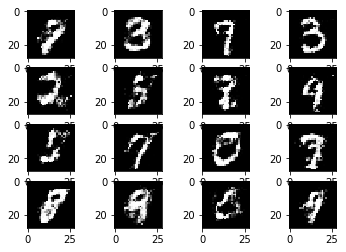

iter: 27000 cost of discriminator -0.25912905 cost of generator -0.32397264
mean predicted prob for actual data: 0.6939706206321716, mean predicted prob for fake data: 0.3239726424217224


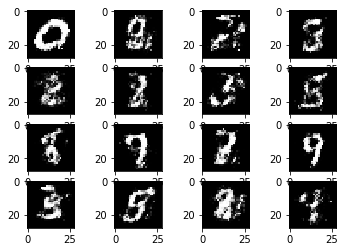

iter: 28000 cost of discriminator -0.26738 cost of generator -0.36805594
mean predicted prob for actual data: 0.7323914766311646, mean predicted prob for fake data: 0.36805593967437744


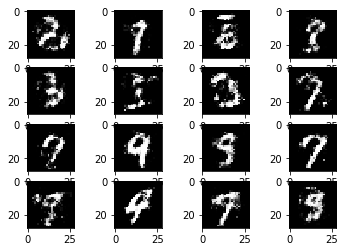

iter: 29000 cost of discriminator -0.24531558 cost of generator -0.3812514
mean predicted prob for actual data: 0.7421231269836426, mean predicted prob for fake data: 0.38125139474868774


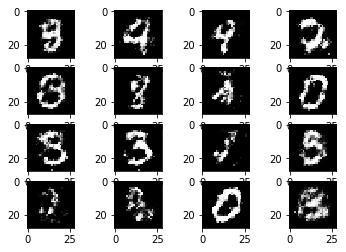

iter: 30000 cost of discriminator -0.23395665 cost of generator -0.43303978
mean predicted prob for actual data: 0.7610927820205688, mean predicted prob for fake data: 0.4330397844314575


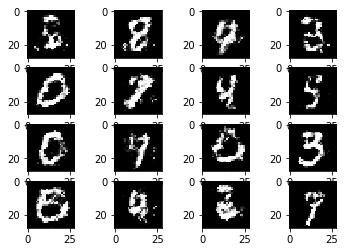

iter: 31000 cost of discriminator -0.17781925 cost of generator -0.41142887
mean predicted prob for actual data: 0.7560184001922607, mean predicted prob for fake data: 0.41142886877059937


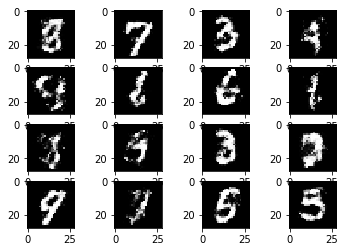

iter: 32000 cost of discriminator -0.32890666 cost of generator -0.36920828
mean predicted prob for actual data: 0.7475035786628723, mean predicted prob for fake data: 0.36920827627182007


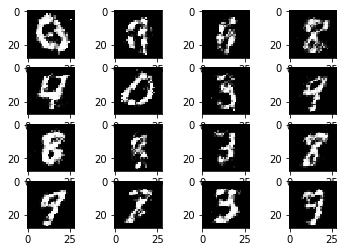

iter: 33000 cost of discriminator -0.2858743 cost of generator -0.38349545
mean predicted prob for actual data: 0.7439215779304504, mean predicted prob for fake data: 0.3834954500198364


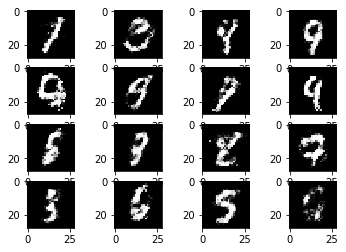

iter: 34000 cost of discriminator -0.2561642 cost of generator -0.38241568
mean predicted prob for actual data: 0.7333365678787231, mean predicted prob for fake data: 0.38241568207740784


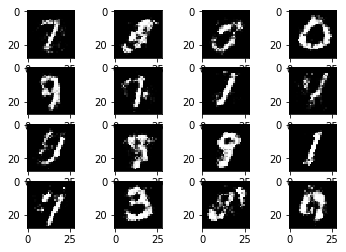

iter: 35000 cost of discriminator -0.31616372 cost of generator -0.3648281
mean predicted prob for actual data: 0.7119753360748291, mean predicted prob for fake data: 0.36482810974121094


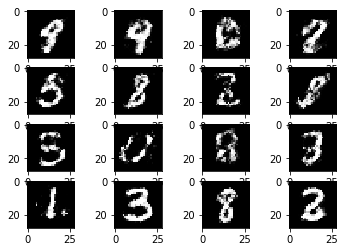

iter: 36000 cost of discriminator -0.27765816 cost of generator -0.3761752
mean predicted prob for actual data: 0.7192133665084839, mean predicted prob for fake data: 0.376175194978714


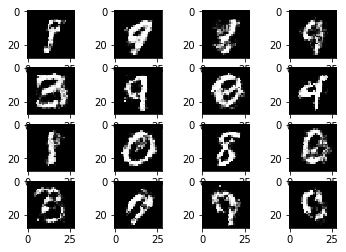

iter: 37000 cost of discriminator -0.2849288 cost of generator -0.35163906
mean predicted prob for actual data: 0.6997479200363159, mean predicted prob for fake data: 0.351639062166214


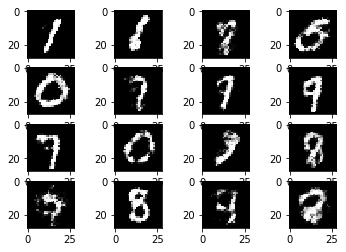

iter: 38000 cost of discriminator -0.18742147 cost of generator -0.3416932
mean predicted prob for actual data: 0.6447138786315918, mean predicted prob for fake data: 0.3416931927204132


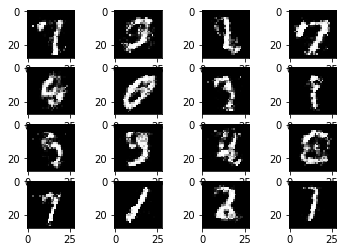

iter: 39000 cost of discriminator -0.21420212 cost of generator -0.34987223
mean predicted prob for actual data: 0.6526938676834106, mean predicted prob for fake data: 0.3498722314834595


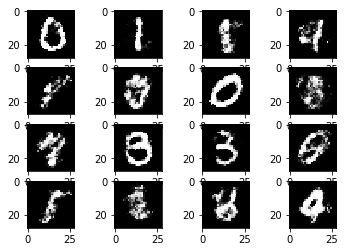

iter: 40000 cost of discriminator -0.28881994 cost of generator -0.39720964
mean predicted prob for actual data: 0.7679236531257629, mean predicted prob for fake data: 0.39720964431762695


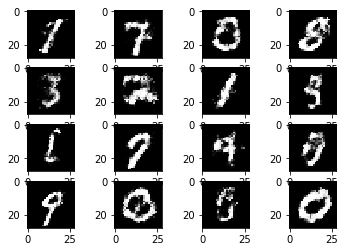

iter: 41000 cost of discriminator -0.2886725 cost of generator -0.37490854
mean predicted prob for actual data: 0.7168145179748535, mean predicted prob for fake data: 0.37490853667259216


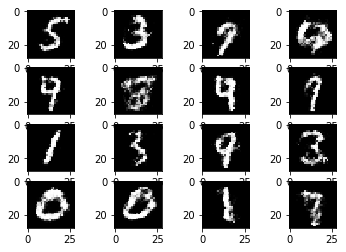

iter: 42000 cost of discriminator -0.2636517 cost of generator -0.29585063
mean predicted prob for actual data: 0.6297672390937805, mean predicted prob for fake data: 0.29585063457489014


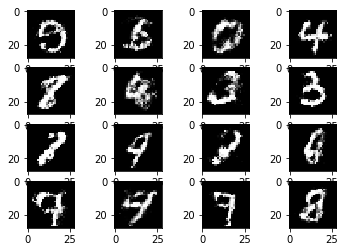

iter: 43000 cost of discriminator -0.28532776 cost of generator -0.39119652
mean predicted prob for actual data: 0.7169942259788513, mean predicted prob for fake data: 0.39119651913642883


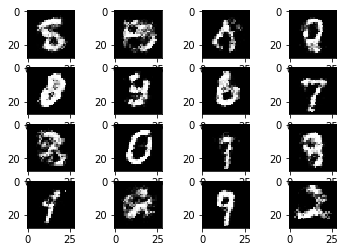

iter: 44000 cost of discriminator -0.26654086 cost of generator -0.31593978
mean predicted prob for actual data: 0.665648341178894, mean predicted prob for fake data: 0.3159397840499878


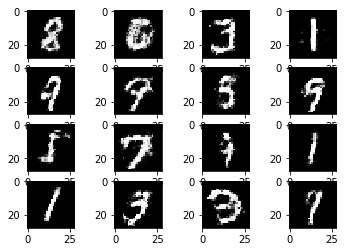

iter: 45000 cost of discriminator -0.26852494 cost of generator -0.38578448
mean predicted prob for actual data: 0.7191753387451172, mean predicted prob for fake data: 0.38578447699546814


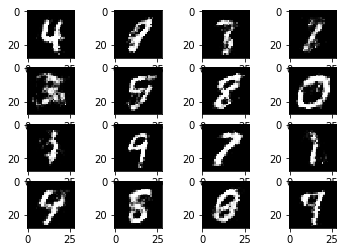

iter: 46000 cost of discriminator -0.25949627 cost of generator -0.3690097
mean predicted prob for actual data: 0.6801141500473022, mean predicted prob for fake data: 0.36900970339775085


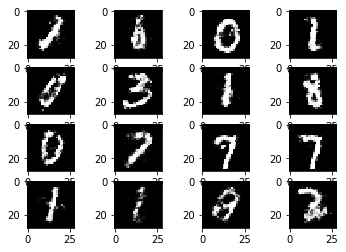

iter: 47000 cost of discriminator -0.2920751 cost of generator -0.34898746
mean predicted prob for actual data: 0.6982808113098145, mean predicted prob for fake data: 0.3489874601364136


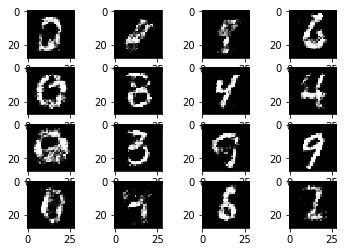

iter: 48000 cost of discriminator -0.19809285 cost of generator -0.411803
mean predicted prob for actual data: 0.7201930284500122, mean predicted prob for fake data: 0.4118030071258545


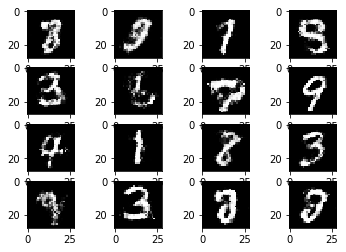

iter: 49000 cost of discriminator -0.29452565 cost of generator -0.36909574
mean predicted prob for actual data: 0.7113044857978821, mean predicted prob for fake data: 0.36909574270248413


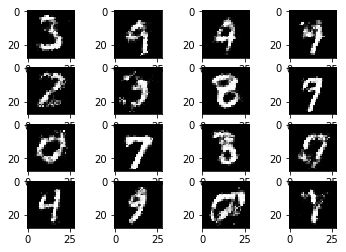

iter: 50000 cost of discriminator -0.23556873 cost of generator -0.35374463
mean predicted prob for actual data: 0.6933158040046692, mean predicted prob for fake data: 0.35374462604522705


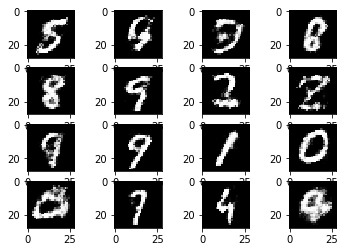

iter: 51000 cost of discriminator -0.2724049 cost of generator -0.37684917
mean predicted prob for actual data: 0.7075843811035156, mean predicted prob for fake data: 0.3768491744995117


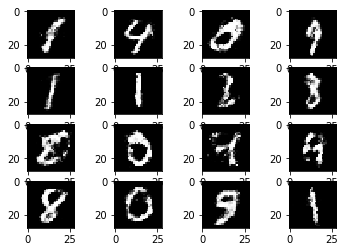

iter: 52000 cost of discriminator -0.22963095 cost of generator -0.3500396
mean predicted prob for actual data: 0.6462651491165161, mean predicted prob for fake data: 0.35003960132598877


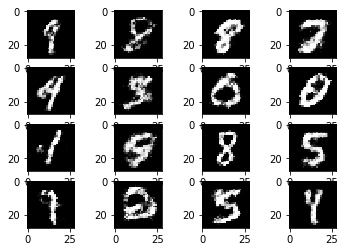

iter: 53000 cost of discriminator -0.28395522 cost of generator -0.3117079
mean predicted prob for actual data: 0.6668388843536377, mean predicted prob for fake data: 0.31170791387557983


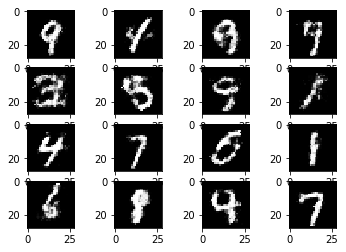

iter: 54000 cost of discriminator -0.1882694 cost of generator -0.3999105
mean predicted prob for actual data: 0.7011557817459106, mean predicted prob for fake data: 0.39991050958633423


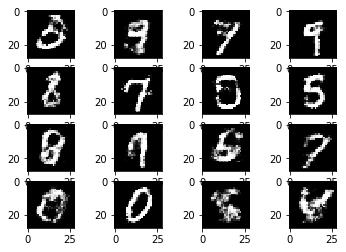

iter: 55000 cost of discriminator -0.25507027 cost of generator -0.34882632
mean predicted prob for actual data: 0.6779502630233765, mean predicted prob for fake data: 0.3488263189792633


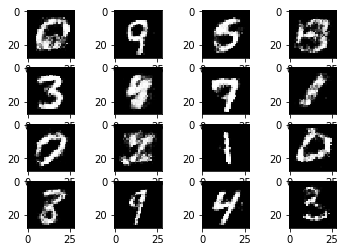

iter: 56000 cost of discriminator -0.14190578 cost of generator -0.28852987
mean predicted prob for actual data: 0.592186689376831, mean predicted prob for fake data: 0.2885298728942871


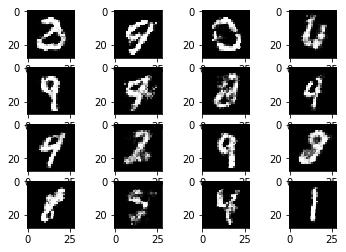

iter: 57000 cost of discriminator -0.26950288 cost of generator -0.36975262
mean predicted prob for actual data: 0.6947282552719116, mean predicted prob for fake data: 0.3697526156902313


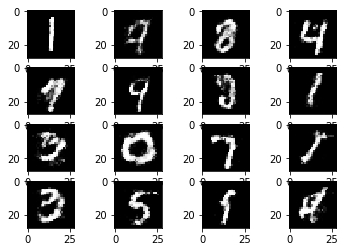

iter: 58000 cost of discriminator -0.27510253 cost of generator -0.35592175
mean predicted prob for actual data: 0.6719663143157959, mean predicted prob for fake data: 0.35592174530029297


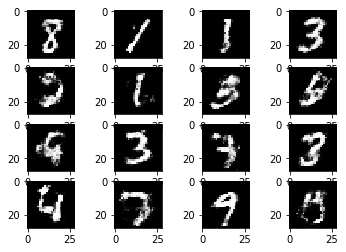

iter: 59000 cost of discriminator -0.22193217 cost of generator -0.33204442
mean predicted prob for actual data: 0.631199836730957, mean predicted prob for fake data: 0.33204442262649536


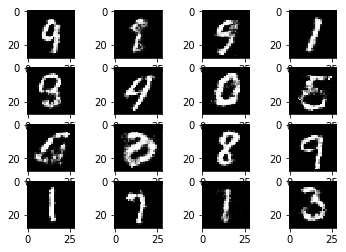

In [6]:
with tf.Session() as sess:
    sess.run(init)

    for i in range(60000):
        for j in range(5):
            batch_x, _ = mnist.train.next_batch(batch_size)
            x_value = batch_x
        # x_value = 2 * batch_x.astype(np.float32) - 1
            z_value = np.random.uniform(-1, 1, size=(batch_size, dim)).astype(np.float32)
            sess.run(d_trainer, feed_dict={x:batch_x, z_noise:z_value, keep_prob:1})

        z_value2 = np.random.uniform(-1, 1, size=(batch_size, dim)).astype(np.float32)
        sess.run(g_trainer, feed_dict={x:x_value, z_noise:z_value2, keep_prob:1})

        # c1, c2 = sess.run([disc_loss, gen_loss], feed_dict={x:x_value, z_noise:z_value, keep_prob:1})
        # if np.isnan(c1) or np.isnan(c2):
        #     print ('iter:', i, 'cost of discriminator', c1, 'cost of generator', c2)
        #     break
        # prev_grads = sess.run([disc_grad, gen_grad], feed_dict={x:x_value, z_noise:z_value2, keep_prob:1})
        # prev_weights = sess.run([weights_g, weights_d])
        # prev_loss = sess.run([disc_loss, gen_loss], feed_dict={x:x_value, z_noise:z_value, keep_prob:1})
        # prev_input = batch_x, z_value
        # prev_output = sess.run(out_gen, feed_dict={x:x_value, z_noise:z_value2, keep_prob:1})

        if (i % 1000 == 0) and (i > 1):
            c1, c2 = sess.run([disc_loss, gen_loss], feed_dict={x:x_value, z_noise:z_value, keep_prob:1})
            print ('iter:', i, 'cost of discriminator', c1, 'cost of generator', c2)
            pdata, pfake = sess.run([tf.reduce_mean(y_data), tf.reduce_mean(y_fake)],
                                    feed_dict={x:x_value, z_noise:z_value, keep_prob:1})
            print(f'mean predicted prob for actual data: {pdata}, mean predicted prob for fake data: {pfake}')
            z_sample = np.random.uniform(-1, 1, size=(batch_size, dim)).astype(np.float32)
            out_val_img = sess.run(out_gen, feed_dict={z_noise: z_sample})
            imgs = 0.5*(out_val_img + 1)
            for k in range(16):
                plt.subplot(4, 4, k + 1)
                image = np.reshape(imgs[k], (28,28))
                plt.imshow(image, cmap='gray')
            plt.show()

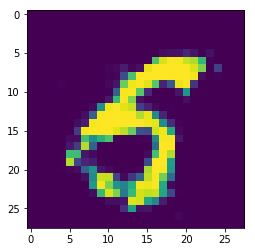

In [9]:
z_sample = np.random.uniform(-1, 1, size=(batch_size,dim)).astype(np.float32)
out_val_img = sess.run(out_gen,feed_dict={z_noise: z_sample})     
img = 0.5*(out_val_img[3,:] + 1)
img = np.reshape(img, (28 , 28))
plt.imshow(img * 255)
plt.show()

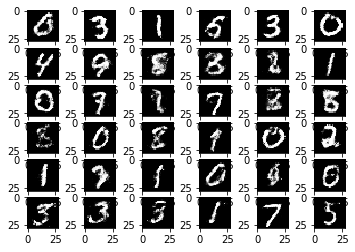

In [10]:
# saver.save(sess, "newgan_",global_step=i)
imgs = 0.5*(out_val_img + 1)
for k in range(36):
    plt.subplot(6,6,k+1)
    image = np.reshape(imgs[k],(28,28))
    plt.imshow(image, cmap='gray')

# Try to generate specific numbers (conditional WGAN)

In [1]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from tensorflow.python import debug as tf_debug
import tensorflow.contrib as tc
import tensorflow.contrib.layers as tcl

%matplotlib inline

/home/rluo/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18307647559674717806, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10855078298
 locality {
   bus_id: 1
 }
 incarnation: 9656911422243961889
 physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:01:00.0, compute capability: 5.2", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 11989689959
 locality {
   bus_id: 1
 }
 incarnation: 1814007580329294752
 physical_device_desc: "device: 1, name: GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2"]

In [3]:
def leaky_relu(x, alpha=0.1):
    return tf.maximum(tf.minimum(0.0, alpha * x), x)

For the generator, I extend the input noise with the one-hot encoding of the digit that I want to generate an image for

In [4]:
def gen_net(z, digit, hidden_dims, out_dim):
    with tf.variable_scope('gen', reuse=tf.AUTO_REUSE) as vs:
        fc = tf.concat([z, digit], axis=1)
        for dim in hidden_dims:
            fc = tcl.fully_connected(
                    fc, dim,
                    weights_initializer=tf.random_normal_initializer(stddev=0.02),
                    weights_regularizer=tc.layers.l2_regularizer(2.5e-5),
                    activation_fn=tcl.batch_norm
            )
            fc = leaky_relu(fc)
        fc = tcl.fully_connected(
            fc, out_dim,
            weights_initializer=tf.random_normal_initializer(stddev=0.02),
            weights_regularizer=tc.layers.l2_regularizer(2.5e-5),
            activation_fn=tf.sigmoid
        )
        
        return fc

For the critic, I extended the output from convolution layers with the one-hot encoding of the digit that was supposed to match with the generated image, and then let them go through two fully-connected layers before outputting a probability. The probability indicates how likely the input image is real and matches with the digit given.

In [5]:
def crit_net(x, digits, hidden_dims):
    with tf.variable_scope('critic', reuse=tf.AUTO_REUSE) as vs:
        bs = tf.shape(x)[0]
        x = tf.reshape(x, [bs, 28, 28, 1])
        conv1 = tc.layers.convolution2d(
            x, 256, [4, 4], [2, 2],
            weights_initializer=tf.random_normal_initializer(stddev=0.02),
            activation_fn=tf.identity
        )
        conv1 = tcl.max_pool2d(conv1, [2, 2])
        conv2 = tc.layers.convolution2d(
            conv1, 128, [4, 4], [2, 2],
            weights_initializer=tf.random_normal_initializer(stddev=0.02),
            activation_fn=tf.identity
        )
        conv2 = tcl.max_pool2d(conv2, [2, 2])
        conv2 = tcl.flatten(conv2)
        fc1 = tc.layers.fully_connected(
            conv2, 64,
            weights_initializer=tf.random_normal_initializer(stddev=0.02),
            activation_fn=tcl.layer_norm
        )
        fc1 = leaky_relu(tc.layers.layer_norm(fc1))
        fc2 = tc.layers.fully_connected(
            tf.concat([fc1, digits], axis=1), 10,
            weights_initializer=tf.random_normal_initializer(stddev=0.02),
            activation_fn=tcl.layer_norm
        )
        fc2 = leaky_relu(fc2)
        fc3 = tc.layers.fully_connected(fc2, 1, activation_fn=tf.identity)
        return fc3

In [ ]:
z_dim = 100
gen_hidden_dims = [256, 512, 512, 512]
crit_hidden_dims = [512, 256, 64]

batch_size = 275

with tf.device('/device:GPU:0'):


    ## Place holder for the real images
    x_correct = tf.placeholder(tf.float32, [batch_size, 28 * 28], name='x_correct')
    x_correct_digit = tf.placeholder(tf.float32, [batch_size, 10], name='x_correct_digit')
    x_wrong = tf.placeholder(tf.float32, [batch_size, 28 * 28], name='x_wrong')
    x_wrong_digit = tf.placeholder(tf.float32, [batch_size, 10], name='x_wrong_digit')
    ## Place holder for the noise
    z = tf.placeholder(tf.float32, [batch_size, z_dim], name='z')
    z_out = gen_net(z, x_correct_digit, gen_hidden_dims, 28 * 28)
    # Define the ops and weights for Discriminator
    y_correct_data = crit_net(x_correct, x_correct_digit, crit_hidden_dims)
    y_wrong_data = crit_net(x_wrong, x_wrong_digit, crit_hidden_dims)
    y_fake = crit_net(z_out, x_correct_digit, crit_hidden_dims)

    eps = tf.random_uniform([batch_size, 1])
    x_hat = eps * x_correct + (1 - eps) * z_out
    y_mid = crit_net(x_hat, x_correct_digit, crit_hidden_dims)

    lam = 5
    gradients = tf.gradients(y_mid, x_hat)[0]
    crit_loss1 = (tf.reduce_mean(y_fake)
                 - tf.reduce_mean(y_correct_data)
                 + lam * tf.reduce_mean(tf.square(tf.norm(gradients, axis=1) - 1))
                )
    crit_loss2 = (tf.reduce_mean(y_wrong_data)
                 - tf.reduce_mean(y_correct_data)
                )

    gen_loss = -tf.reduce_mean(y_fake)

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        c_adam1 = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.1, beta2=0.9)\
            .minimize(crit_loss1, var_list=[var for var in tf.global_variables() if 'crit' in var.name])
        c_adam2 = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.1, beta2=0.9)\
            .minimize(crit_loss2, var_list=[var for var in tf.global_variables() if 'crit' in var.name])
        g_adam = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.1, beta2=0.9)\
            .minimize(gen_loss, var_list=[var for var in tf.global_variables() if 'gen' in var.name])
    
    init = tf.global_variables_initializer()

Discriminator Loss 1:

$\mathbf{E}_{(x, y)\sim P_{(x, wrong\ label)}}\big[D_{\theta_d}(x, y)\big] - \mathbf{E}_{(x, y)\sim P_{(x, correct\ label)}}\big[D_{\theta_d}(x, y)\big]$

- requires the discriminator to give high scores to real image with correct label and low scores to real image with wrong label

Discriminator Loss 2:

$\mathbf{E}_{(z, y)\sim \Pi(P_{z}, P_{label})}\big[D_{\theta_d}(G_{\theta_g}(z), y)\big] - \mathbf{E}_{(x, y)\sim P_{(x, correct\ label)}}\big[D_{\theta_d}(x, y)\big] + \lambda\big(\Vert\nabla_{\hat{x}}D_{\theta_d}(\hat{x}, y)\Vert_2-1\big)^2$

- Approximation to Wasserstein distance between $P_{(G_{\theta_g}(z), y)}, z\sim P_{z}$ and $P_{(x, correct\ label)}$

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
epoch: 0, 
    cost 1 of discriminator: -2.3141226768493652, 
    cost 2 of discriminator: -0.7396129369735718, 
    cost of generator: 2.370708703994751
    mean critic score for correct data: 0.32287341356277466,
    mean critic score for wrong data: -0.4167395532131195,
    mean critic score for fake data: -2.370708703994751
digits: [2 9 7 7 2 7 7 2 7 8 3 3 2 1 9 1]


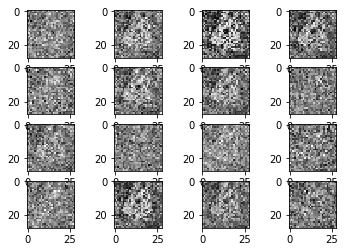

epoch: 1, 
    cost 1 of discriminator: -2.795358180999756, 
    cost 2 of discriminator: -0.993273138999939, 
    cost of generator: 2.509221076965332
    mean critic score for correct data: 0.6732301115989685,
    mean critic score for wrong data: -0.32004299759864807,
    mean critic score for fake data: -2.509221076965332
epoch: 2, 
    cost 1 of discriminator: -2.7610249519348145, 
    cost 2 of discriminator: -1.2536884546279907, 
    cost of generator: 2.630207061767578
    mean critic score for correct data: 0.7166306376457214,
    mean critic score for wrong data: -0.5370578169822693,
    mean critic score for fake data: -2.630207061767578
epoch: 3, 
    cost 1 of discriminator: -3.05684494972229, 
    cost 2 of discriminator: -1.4526331424713135, 
    cost of generator: 2.8207621574401855
    mean critic score for correct data: 0.9909836649894714,
    mean critic score for wrong data: -0.46164947748184204,
    mean critic score for fake data: -2.8207621574401855
epoch: 4, 
  

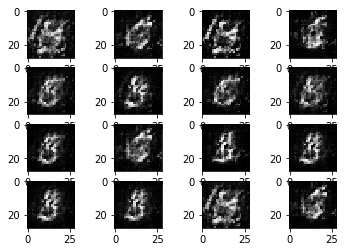

epoch: 11, 
    cost 1 of discriminator: -2.5977625846862793, 
    cost 2 of discriminator: -2.385413646697998, 
    cost of generator: 2.334737539291382
    mean critic score for correct data: 1.5798940658569336,
    mean critic score for wrong data: -0.805519700050354,
    mean critic score for fake data: -2.334737539291382
epoch: 12, 
    cost 1 of discriminator: -2.4505693912506104, 
    cost 2 of discriminator: -2.3884851932525635, 
    cost of generator: 1.9979722499847412
    mean critic score for correct data: 1.6224467754364014,
    mean critic score for wrong data: -0.7660383582115173,
    mean critic score for fake data: -1.9979722499847412
epoch: 13, 
    cost 1 of discriminator: -2.5448689460754395, 
    cost 2 of discriminator: -2.488689422607422, 
    cost of generator: 1.7943967580795288
    mean critic score for correct data: 1.8914555311203003,
    mean critic score for wrong data: -0.5972339510917664,
    mean critic score for fake data: -1.7943967580795288
epoch: 14

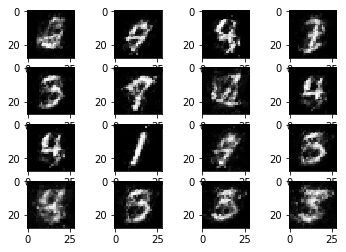

epoch: 21, 
    cost 1 of discriminator: -1.7443015575408936, 
    cost 2 of discriminator: -3.2223825454711914, 
    cost of generator: 0.22444725036621094
    mean critic score for correct data: 2.596869945526123,
    mean critic score for wrong data: -0.6255124807357788,
    mean critic score for fake data: -0.22444725036621094
epoch: 22, 
    cost 1 of discriminator: -1.1681432723999023, 
    cost 2 of discriminator: -3.166447162628174, 
    cost of generator: 0.1548490971326828
    mean critic score for correct data: 2.5081429481506348,
    mean critic score for wrong data: -0.6583042144775391,
    mean critic score for fake data: -0.1548490971326828
epoch: 23, 
    cost 1 of discriminator: -0.9584783315658569, 
    cost 2 of discriminator: -3.2225430011749268, 
    cost of generator: -0.45008203387260437
    mean critic score for correct data: 2.5357351303100586,
    mean critic score for wrong data: -0.6868078708648682,
    mean critic score for fake data: 0.45008203387260437
ep

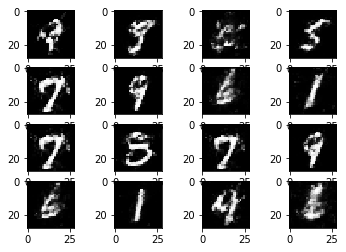

epoch: 31, 
    cost 1 of discriminator: 0.30247360467910767, 
    cost 2 of discriminator: -3.546107769012451, 
    cost of generator: -2.0497732162475586
    mean critic score for correct data: 2.6547114849090576,
    mean critic score for wrong data: -0.8913962841033936,
    mean critic score for fake data: 2.0497732162475586
epoch: 32, 
    cost 1 of discriminator: 0.5073829293251038, 
    cost 2 of discriminator: -3.6227807998657227, 
    cost of generator: -2.3281543254852295
    mean critic score for correct data: 2.6324281692504883,
    mean critic score for wrong data: -0.9903526902198792,
    mean critic score for fake data: 2.3281543254852295
epoch: 33, 
    cost 1 of discriminator: 0.46358752250671387, 
    cost 2 of discriminator: -3.614260673522949, 
    cost of generator: -2.375645637512207
    mean critic score for correct data: 2.7161245346069336,
    mean critic score for wrong data: -0.8981360793113708,
    mean critic score for fake data: 2.375645637512207
epoch: 34

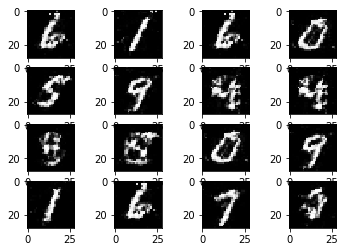

epoch: 41, 
    cost 1 of discriminator: 0.44174981117248535, 
    cost 2 of discriminator: -2.292248249053955, 
    cost of generator: -2.449807643890381
    mean critic score for correct data: 2.5847270488739014,
    mean critic score for wrong data: 0.29247891902923584,
    mean critic score for fake data: 2.449807643890381
epoch: 42, 
    cost 1 of discriminator: -0.09359987080097198, 
    cost 2 of discriminator: -2.217407464981079, 
    cost of generator: -1.885627031326294
    mean critic score for correct data: 2.1849162578582764,
    mean critic score for wrong data: -0.032491184771060944,
    mean critic score for fake data: 1.885627031326294
epoch: 43, 
    cost 1 of discriminator: 0.04138535261154175, 
    cost 2 of discriminator: -2.2797412872314453, 
    cost of generator: -2.301837921142578
    mean critic score for correct data: 2.5504183769226074,
    mean critic score for wrong data: 0.27067700028419495,
    mean critic score for fake data: 2.301837921142578
epoch: 44

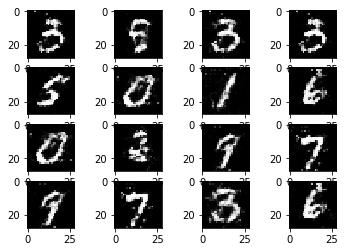

epoch: 51, 
    cost 1 of discriminator: 0.2940831482410431, 
    cost 2 of discriminator: -2.1727349758148193, 
    cost of generator: -2.381866216659546
    mean critic score for correct data: 2.46185302734375,
    mean critic score for wrong data: 0.2891180217266083,
    mean critic score for fake data: 2.381866216659546
epoch: 52, 
    cost 1 of discriminator: 0.18076837062835693, 
    cost 2 of discriminator: -2.2084171772003174, 
    cost of generator: -2.2755446434020996
    mean critic score for correct data: 2.427057981491089,
    mean critic score for wrong data: 0.21864086389541626,
    mean critic score for fake data: 2.2755446434020996
epoch: 53, 
    cost 1 of discriminator: 0.5644271373748779, 
    cost 2 of discriminator: -2.733712911605835, 
    cost of generator: -2.6660826206207275
    mean critic score for correct data: 2.627776861190796,
    mean critic score for wrong data: -0.10593609511852264,
    mean critic score for fake data: 2.6660826206207275
epoch: 54, 
 

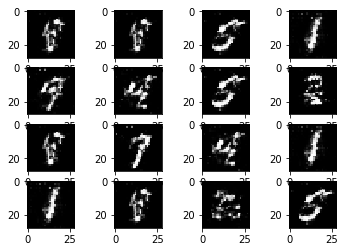

epoch: 61, 
    cost 1 of discriminator: 1.3842692375183105, 
    cost 2 of discriminator: -2.7004408836364746, 
    cost of generator: -2.6866061687469482
    mean critic score for correct data: 2.1051933765411377,
    mean critic score for wrong data: -0.5952474474906921,
    mean critic score for fake data: 2.6866061687469482
epoch: 62, 
    cost 1 of discriminator: 1.1972894668579102, 
    cost 2 of discriminator: -2.6105475425720215, 
    cost of generator: -2.645050048828125
    mean critic score for correct data: 2.125340700149536,
    mean critic score for wrong data: -0.48520684242248535,
    mean critic score for fake data: 2.645050048828125
epoch: 63, 
    cost 1 of discriminator: 0.9825202226638794, 
    cost 2 of discriminator: -2.6170594692230225, 
    cost of generator: -2.5688979625701904
    mean critic score for correct data: 2.06054425239563,
    mean critic score for wrong data: -0.5565152168273926,
    mean critic score for fake data: 2.5688979625701904
epoch: 64, 

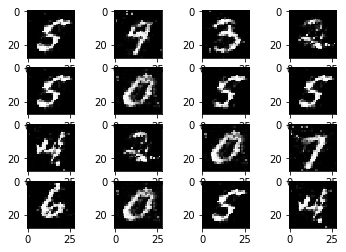

epoch: 71, 
    cost 1 of discriminator: 1.8476442098617554, 
    cost 2 of discriminator: -2.5855088233947754, 
    cost of generator: -2.1156747341156006
    mean critic score for correct data: 1.5898369550704956,
    mean critic score for wrong data: -0.9956719279289246,
    mean critic score for fake data: 2.1156747341156006
epoch: 72, 
    cost 1 of discriminator: 1.907787561416626, 
    cost 2 of discriminator: -2.7126245498657227, 
    cost of generator: -2.0546414852142334
    mean critic score for correct data: 1.5448178052902222,
    mean critic score for wrong data: -1.16780686378479,
    mean critic score for fake data: 2.0546414852142334
epoch: 73, 
    cost 1 of discriminator: 1.7883998155593872, 
    cost 2 of discriminator: -2.483389377593994, 
    cost of generator: -1.904085636138916
    mean critic score for correct data: 1.2915960550308228,
    mean critic score for wrong data: -1.1917932033538818,
    mean critic score for fake data: 1.904085636138916
epoch: 74, 
 

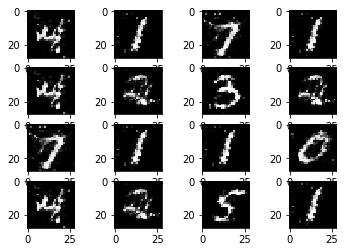

epoch: 81, 
    cost 1 of discriminator: 1.06160306930542, 
    cost 2 of discriminator: -2.0212771892547607, 
    cost of generator: -1.3274257183074951
    mean critic score for correct data: 1.0251747369766235,
    mean critic score for wrong data: -0.9961023926734924,
    mean critic score for fake data: 1.3274257183074951
epoch: 82, 
    cost 1 of discriminator: 1.836309552192688, 
    cost 2 of discriminator: -1.8692312240600586, 
    cost of generator: -1.2015228271484375
    mean critic score for correct data: 0.8235398530960083,
    mean critic score for wrong data: -1.0456913709640503,
    mean critic score for fake data: 1.2015228271484375
epoch: 83, 
    cost 1 of discriminator: 1.2127459049224854, 
    cost 2 of discriminator: -1.7980377674102783, 
    cost of generator: -1.1665719747543335
    mean critic score for correct data: 0.8050447106361389,
    mean critic score for wrong data: -0.9929930567741394,
    mean critic score for fake data: 1.1665719747543335
epoch: 84,

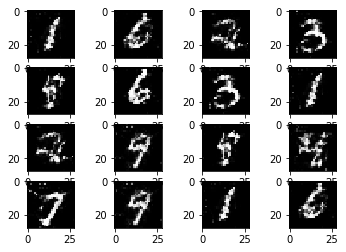

epoch: 91, 
    cost 1 of discriminator: 0.7769298553466797, 
    cost 2 of discriminator: -1.3865947723388672, 
    cost of generator: -0.6948339939117432
    mean critic score for correct data: 0.5223521590232849,
    mean critic score for wrong data: -0.8642426133155823,
    mean critic score for fake data: 0.6948339939117432
epoch: 92, 
    cost 1 of discriminator: 1.0911626815795898, 
    cost 2 of discriminator: -1.3622289896011353, 
    cost of generator: -0.684426486492157
    mean critic score for correct data: 0.4953194856643677,
    mean critic score for wrong data: -0.8669095039367676,
    mean critic score for fake data: 0.684426486492157
epoch: 93, 
    cost 1 of discriminator: 0.9103811979293823, 
    cost 2 of discriminator: -1.1874421834945679, 
    cost of generator: -0.6721266508102417
    mean critic score for correct data: 0.47909024357795715,
    mean critic score for wrong data: -0.7083519101142883,
    mean critic score for fake data: 0.6721266508102417
epoch: 9

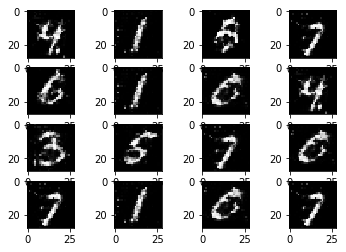

epoch: 101, 
    cost 1 of discriminator: 0.7475073933601379, 
    cost 2 of discriminator: -1.1758842468261719, 
    cost of generator: -0.580533504486084
    mean critic score for correct data: 0.388278603553772,
    mean critic score for wrong data: -0.7876055836677551,
    mean critic score for fake data: 0.580533504486084
epoch: 102, 
    cost 1 of discriminator: 0.6968299746513367, 
    cost 2 of discriminator: -1.1635715961456299, 
    cost of generator: -0.6217864155769348
    mean critic score for correct data: 0.4687773585319519,
    mean critic score for wrong data: -0.6947941780090332,
    mean critic score for fake data: 0.6217864155769348
epoch: 103, 
    cost 1 of discriminator: 1.2422022819519043, 
    cost 2 of discriminator: -1.09780752658844, 
    cost of generator: -0.6235244870185852
    mean critic score for correct data: 0.39229777455329895,
    mean critic score for wrong data: -0.7055097818374634,
    mean critic score for fake data: 0.6235244870185852
epoch: 1

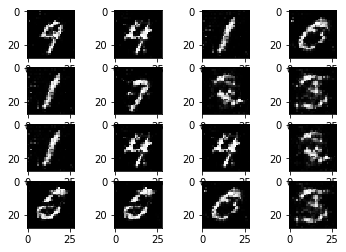

epoch: 111, 
    cost 1 of discriminator: 1.0379631519317627, 
    cost 2 of discriminator: -0.8435101509094238, 
    cost of generator: -0.4123727083206177
    mean critic score for correct data: 0.23757676780223846,
    mean critic score for wrong data: -0.6059333682060242,
    mean critic score for fake data: 0.4123727083206177
epoch: 112, 
    cost 1 of discriminator: 0.9288316369056702, 
    cost 2 of discriminator: -0.9325710535049438, 
    cost of generator: -0.37667399644851685
    mean critic score for correct data: 0.17952074110507965,
    mean critic score for wrong data: -0.7530503273010254,
    mean critic score for fake data: 0.37667399644851685
epoch: 113, 
    cost 1 of discriminator: 1.0032234191894531, 
    cost 2 of discriminator: -0.8011882305145264, 
    cost of generator: -0.3551015257835388
    mean critic score for correct data: 0.1823062002658844,
    mean critic score for wrong data: -0.6188820600509644,
    mean critic score for fake data: 0.3551015257835388


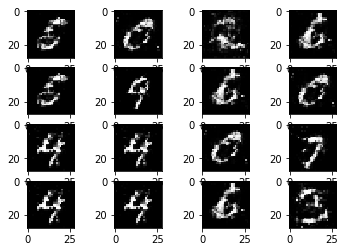

epoch: 121, 
    cost 1 of discriminator: 1.3724756240844727, 
    cost 2 of discriminator: -1.0670249462127686, 
    cost of generator: -0.5202169418334961
    mean critic score for correct data: 0.30670565366744995,
    mean critic score for wrong data: -0.7603193521499634,
    mean critic score for fake data: 0.5202169418334961
epoch: 122, 
    cost 1 of discriminator: 1.205834984779358, 
    cost 2 of discriminator: -1.0307024717330933, 
    cost of generator: -0.5603472590446472
    mean critic score for correct data: 0.318497896194458,
    mean critic score for wrong data: -0.7122045755386353,
    mean critic score for fake data: 0.5603472590446472


In [ ]:
# Read (reset epochs) the MNIST datadet
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

costc1 = []
costc2 = []
costg = []
pcorrect_list = []
pwrong_list = []
pfake_list = []


gpu_options = tf.GPUOptions(allow_growth=False)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    epoch = 0
    while mnist.train.epochs_completed < 200:
        for _ in range(5):
            
            x_correct_sample, x_correct_label = mnist.train.next_batch(batch_size)
            x_wrong_sample, x_wrong_original_label = mnist.test.next_batch(batch_size)
            
            x_wrong_label = np.zeros((batch_size, 10))
            x_wrong_original_digits = np.argmax(x_wrong_original_label, axis=1)
            for j in range(batch_size):
                wrong_digit = np.random.choice([k for k in range(10) if not k == x_wrong_original_digits[j]])
                x_wrong_label[j][wrong_digit] = 1
            
            z_in = np.random.uniform(-1, 1, size=(batch_size, z_dim)).astype(np.float32)

            sess.run(c_adam1, feed_dict={
                x_correct: x_correct_sample,
                x_correct_digit: x_correct_label,
                x_wrong: x_wrong_sample,
                x_wrong_digit: x_wrong_label,
                z: z_in})
            sess.run(c_adam2, feed_dict={
                x_correct: x_correct_sample,
                x_correct_digit: x_correct_label,
                x_wrong: x_wrong_sample,
                x_wrong_digit: x_wrong_label,
                z: z_in})
        
        pcorrect, pfake = sess.run([tf.reduce_mean(y_correct_data),
                                    tf.reduce_mean(y_fake)],
                                   feed_dict={
                                       x_correct: x_correct_sample,
                                       x_correct_digit: x_correct_label,
                                       x_wrong: x_wrong_sample,
                                       x_wrong_digit: x_wrong_label,
                                       z: z_in})
        if pcorrect < pfake:
            for _ in range(10):
                x_correct_sample, x_correct_label = mnist.train.next_batch(batch_size)
                z_in = np.random.uniform(-1, 1, size=(batch_size, z_dim)).astype(np.float32)
                sess.run(c_adam1, feed_dict={
                    x_correct: x_correct_sample,
                    x_correct_digit: x_correct_label,
                    x_wrong: x_wrong_sample,
                    x_wrong_digit: x_wrong_label,
                    z: z_in})

        sess.run(g_adam, feed_dict={
                x_correct: x_correct_sample,
                x_correct_digit: x_correct_label,
                x_wrong: x_wrong_sample,
                x_wrong_digit: x_wrong_label,
                z: z_in})
 
        if (mnist.train.epochs_completed > epoch):
            c1, c2, g1 = sess.run([crit_loss1, crit_loss2, gen_loss], feed_dict={
                x_correct: x_correct_sample,
                x_correct_digit: x_correct_label,
                x_wrong: x_wrong_sample,
                x_wrong_digit: x_wrong_label,
                z: z_in})
            costc1.append(c1)
            costc2.append(c2)
            costg.append(g1)
            print (f'''epoch: {epoch}, 
    cost 1 of discriminator: {c1}, 
    cost 2 of discriminator: {c2}, 
    cost of generator: {g1}''')
            pcorrect, pwrong, pfake = sess.run([tf.reduce_mean(y_correct_data), 
                                                tf.reduce_mean(y_wrong_data), 
                                                tf.reduce_mean(y_fake)],
                                               feed_dict={
                                                   x_correct: x_correct_sample,
                                                   x_correct_digit: x_correct_label,
                                                   x_wrong: x_wrong_sample,
                                                   x_wrong_digit: x_wrong_label,
                                                   z: z_in})
            pcorrect_list.append(pcorrect)
            pwrong_list.append(pwrong)
            pfake_list.append(pfake)
            print(f'''    mean critic score for correct data: {pcorrect},
    mean critic score for wrong data: {pwrong},
    mean critic score for fake data: {pfake}''')
            
        if (mnist.train.epochs_completed > epoch) and (epoch % 10 == 0):
            z_sample = np.random.uniform(-1, 1, size=(batch_size, z_dim)).astype(np.float32)
            digit_sample = np.random.choice([j for j in range(10)], size = batch_size)
            digit_sample_one_hot = np.zeros((batch_size, 10))
            for j in range(batch_size):
                digit_sample_one_hot[j][digit_sample[j]] = 1
            out_val_img = sess.run(z_out, feed_dict={z: z_sample, x_correct_digit: digit_sample_one_hot})
            imgs = 0.5*(out_val_img + 1)
            for k in range(16):
                plt.subplot(4, 4, k + 1)
                image = np.reshape(imgs[k], (28,28))
                plt.imshow(image, cmap='gray')
            print(f'digits: {digit_sample[:16]}')
            plt.show()
            
        epoch = mnist.train.epochs_completed

iter: 1000, 
    cost 1 of discriminator: -0.7554242610931396, 
    cost 2 of discriminator: -0.00021141767501831055, 
    cost of generator: -0.11276029795408249
    mean predicted prob for correct data: 0.9545503854751587,
    mean predicted prob for wrong data: 0.9543389678001404,
    mean predicted prob for fake data: 0.11276029795408249
digits: [6 9 0 7 1 4 1 6 3 2 5 9 5 4 5 5]


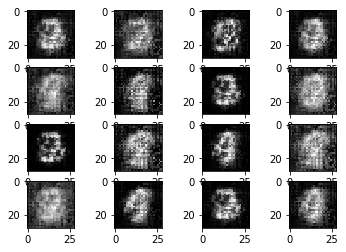

iter: 2000, 
    cost 1 of discriminator: -0.8979192972183228, 
    cost 2 of discriminator: -0.0015904903411865234, 
    cost of generator: -0.04446173086762428
    mean predicted prob for correct data: 0.9703676700592041,
    mean predicted prob for wrong data: 0.9687771797180176,
    mean predicted prob for fake data: 0.04446173086762428
digits: [3 2 6 5 7 4 8 5 1 2 4 1 8 4 6 6]


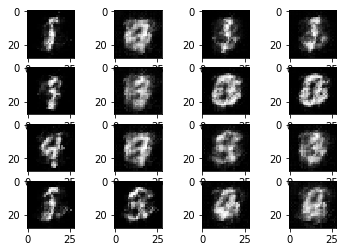

iter: 3000, 
    cost 1 of discriminator: -0.8637803792953491, 
    cost 2 of discriminator: 0.0203130841255188, 
    cost of generator: -0.04897205904126167
    mean predicted prob for correct data: 0.9420416355133057,
    mean predicted prob for wrong data: 0.9623547196388245,
    mean predicted prob for fake data: 0.04897205904126167
digits: [0 3 0 0 9 3 4 3 6 7 7 3 5 1 6 5]


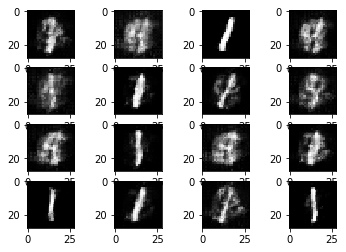

iter: 4000, 
    cost 1 of discriminator: -0.790328860282898, 
    cost 2 of discriminator: -0.02499079704284668, 
    cost of generator: -0.07210199534893036
    mean predicted prob for correct data: 0.9268436431884766,
    mean predicted prob for wrong data: 0.9018528461456299,
    mean predicted prob for fake data: 0.07210199534893036
digits: [4 9 9 8 7 9 3 7 1 7 2 5 4 7 8 8]


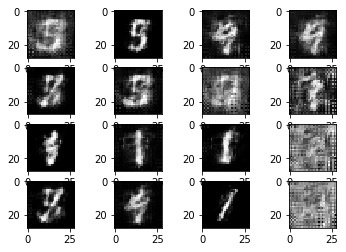

iter: 5000, 
    cost 1 of discriminator: -0.7710333466529846, 
    cost 2 of discriminator: -0.05983668565750122, 
    cost of generator: -0.05838896334171295
    mean predicted prob for correct data: 0.9325113892555237,
    mean predicted prob for wrong data: 0.8726747035980225,
    mean predicted prob for fake data: 0.05838896334171295
digits: [0 7 0 7 5 6 8 2 7 9 8 6 9 6 1 5]


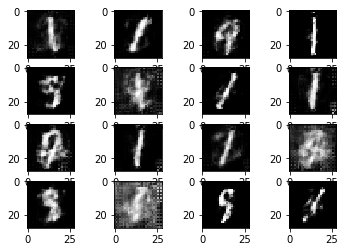

iter: 6000, 
    cost 1 of discriminator: -0.8283115029335022, 
    cost 2 of discriminator: -0.037207722663879395, 
    cost of generator: -0.06539160758256912
    mean predicted prob for correct data: 0.9241719245910645,
    mean predicted prob for wrong data: 0.8869642019271851,
    mean predicted prob for fake data: 0.06539160758256912
digits: [5 8 8 5 1 9 1 8 0 2 6 9 1 2 3 0]


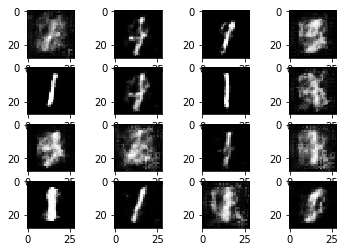

iter: 7000, 
    cost 1 of discriminator: 0.12792101502418518, 
    cost 2 of discriminator: 0.06983059644699097, 
    cost of generator: -0.29331299662590027
    mean predicted prob for correct data: 0.6832577586174011,
    mean predicted prob for wrong data: 0.7530883550643921,
    mean predicted prob for fake data: 0.29331299662590027
digits: [0 1 1 5 3 5 3 6 4 7 8 8 0 6 3 1]


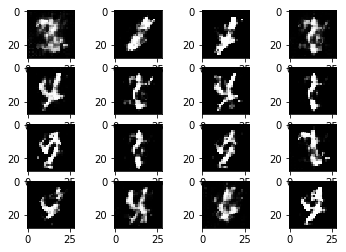

KeyboardInterrupt: 

In [11]:
costc1 = []
costc2 = []
costg = []
gpu_options = tf.GPUOptions(allow_growth=False)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)

    for i in range(60000):
        for _ in range(5):
            
            x_correct_sample, x_correct_label = mnist.train.next_batch(batch_size)
            x_wrong_sample, x_wrong_original_label = mnist.train.next_batch(batch_size)
            
            x_wrong_label = np.zeros((100, 10))
            x_wrong_original_digits = np.argmax(x_wrong_original_label, axis=1)
            for j in range(100):
                wrong_digit = np.random.choice([k for k in range(10) if not k == x_wrong_original_digits[j]])
                x_wrong_label[j][wrong_digit] = 1
            
            z_in = np.random.uniform(-1, 1, size=(batch_size, z_dim)).astype(np.float32)
            sess.run(c_adam1, feed_dict={
                x_correct: x_correct_sample,
                x_correct_digit: x_correct_label,
                x_wrong: x_wrong_sample,
                x_wrong_digit: x_wrong_label,
                z: z_in})

        sess.run(g_adam, feed_dict={
                x_correct: x_correct_sample,
                x_correct_digit: x_correct_label,
                x_wrong: x_wrong_sample,
                x_wrong_digit: x_wrong_label,
                z: z_in})
 
        if (i % 1000 == 0) and (i > 1):
            c1, c2, g1 = sess.run([crit_loss1, crit_loss2, gen_loss], feed_dict={
                x_correct: x_correct_sample,
                x_correct_digit: x_correct_label,
                x_wrong: x_wrong_sample,
                x_wrong_digit: x_wrong_label,
                z: z_in})
            costc1.append(c1)
            costc2.append(c2)
            costg.append(g1)
            print (f'''iter: {i}, 
    cost 1 of discriminator: {c1}, 
    cost 2 of discriminator: {c2}, 
    cost of generator: {g1}''')
            pcorrect, pwrong, pfake = sess.run([tf.reduce_mean(y_correct_data), 
                                                tf.reduce_mean(y_wrong_data), 
                                                tf.reduce_mean(y_fake)],
                                               feed_dict={
                                                   x_correct: x_correct_sample,
                                                   x_correct_digit: x_correct_label,
                                                   x_wrong: x_wrong_sample,
                                                   x_wrong_digit: x_wrong_label,
                                                   z: z_in})
            print(f'''    mean predicted prob for correct data: {pcorrect},
    mean predicted prob for wrong data: {pwrong},
    mean predicted prob for fake data: {pfake}''')
            z_sample = np.random.uniform(-1, 1, size=(batch_size, z_dim)).astype(np.float32)
            digit_sample = np.random.choice([j for j in range(10)], size = batch_size)
            digit_sample_o.ne_hot = np.zeros((100, 10))
            for j in range(100):
                digit_sample_one_hot[j][digit_sample[j]] = 1
            out_val_img = sess.run(z_out, feed_dict={z: z_sample, x_correct_digit: digit_sample_one_hot})
            imgs = 0.5*(out_val_img + 1)
            for k in range(16):
                plt.subplot(4, 4, k + 1)
                image = np.reshape(imgs[k], (28,28))
                plt.imshow(image, cmap='gray')
            print(f'digits: {digit_sample[:16]}')
            plt.show()

In [14]:
def gen_net(z, hidden_dims, out_dim):
    with tf.VariableScope('g', reuse=tf.AUTO_REUSE) as vs:
        fc = z
        for dim in hidden_dims:
            fc = tcl.fully_connected(
                    fc, dim,
                    weights_initializer=tf.random_normal_initializer(stddev=0.02),
                    weights_regularizer=tc.layers.l2_regularizer(2.5e-5),
                    activation_fn=tcl.layer_norm
            )
            fc = leaky_relu(fc)
        fc = tcl.fully_connected(
            fc, out_dim,
            weights_initializer=tf.random_normal_initializer(stddev=0.02),
            weights_regularizer=tc.layers.l2_regularizer(2.5e-5),
            activation_fn=tf.sigmoid
        )
        
        return fc

In [1]:
def crit_net(x):
    with tf.VariableScope('c', reuse=tf.AUTO_REUSE) as vs:
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, [batch_size, 28, 28, 1])
        conv1 = tc.layers.convolution2d(
            x, 64, [4, 4], [2, 2],
            weights_initializer=tf.random_normal_initializer(stddev=0.02),
            activation_fn=tf.identity
        )
        conv1 = leaky_relu(conv1)
        conv2 = tc.layers.convolution2d(
            conv1, 128, [4, 4], [2, 2],
            weights_initializer=tf.random_normal_initializer(stddev=0.02),
            activation_fn=tf.identity
        )
        conv2 = leaky_relu(tc.layers.batch_norm(conv2))
        conv2 = tcl.flatten(conv2)
        fc1 = tc.layers.fully_connected(
            conv2, 1024,
            weights_initializer=tf.random_normal_initializer(stddev=0.02),
            activation_fn=tf.identity
        )
        fc1 = leaky_relu(tc.layers.layer_norm(fc1))
        fc2 = tc.layers.fully_connected(fc1, 1, activation_fn=tf.sigmoid)
        return fc2

In [ ]:
batch_size = 64
dim = 100
num_batches = 50000